# Projekt1
## Wstęp do uczenia maszynowego
## Smartphone activity
### Hubert Kozubek Arkadiusz Kniaź


### Wstęp 
Zadanie projektowe polegało na zbudowaniu modelów klasyfikacyjnych na podstawie danych zawartych w pliku 'smartphone_activity_dataset.csv'. Cel zadania polegał na zaklasyfikowaniu czy osoba korzystająca z telefonu akurat szła, szła po schodach w górę lub w dół, leżała, stała czy siedziała. Predykcji należało dokonać na podstawie kolumn zawierających informacje z wielu czujników, m.in. informację o przyspieszeniu w osi Z, nachyleniu telefonu itp.

In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as XGB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve 
from sklearn import metrics

from scipy.stats import randint, uniform
from sklearn.tree import plot_tree
from sklearn.manifold  import TSNE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from math import floor
from sklearn.inspection import permutation_importance

Dane zostały podzielone na dwa podzbiory: treningowy i testowy.

In [196]:
# df=pd.read_csv('smartphone_activity_dataset.csv')
# training_data, testing_data = train_test_split(df, test_size=0.3)
# training_data.to_csv("training_data.csv")
# testing_data.to_csv("testing_data.csv")

In [197]:
df=pd.read_csv('training_data.csv').iloc[:,1:]
df_test=pd.read_csv('testing_data.csv').iloc[:,1:]
columns_info = pd.read_csv('attributes_smartphone_activity.csv')

In [198]:
columns_info

,name,type,description
0,feature_1,float,tBodyAcc-mean()-X
1,feature_2,float,tBodyAcc-mean()-Y
2,feature_3,float,tBodyAcc-mean()-Z
3,feature_4,float,tBodyAcc-std()-X
4,feature_5,float,tBodyAcc-std()-Y
...,...,...,...
557,feature_558,float,"angle(tBodyGyroJerkMean,gravityMean)"
558,feature_559,float,"angle(X,gravityMean)"
559,feature_560,float,"angle(Y,gravityMean)"
560,feature_561,float,"angle(Z,gravityMean)"


In [199]:
dic = {1:'Walking', 2:'Walking upstairs', 3:'Walking Downstairs', 4:'Sitting', 5:'Standing', 6:'Laying'}
cls_order = ['Walking', 'Walking upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']

In [200]:
graph = df.copy(deep=True)
graph['activity'] = graph['activity'].map(dic)

Rozkład poszczególnych kategorii przedstawiono na wykresie poniżej.
Z wykresu można wyczytać, że liczba przykładów należących do danej kategorie są rozłożone w miarę równomiernie. Z tego też powodu głównym wyznacznikiem oceniającym jakość modelu będzie accuracy.

<AxesSubplot:xlabel='count', ylabel='activity'>

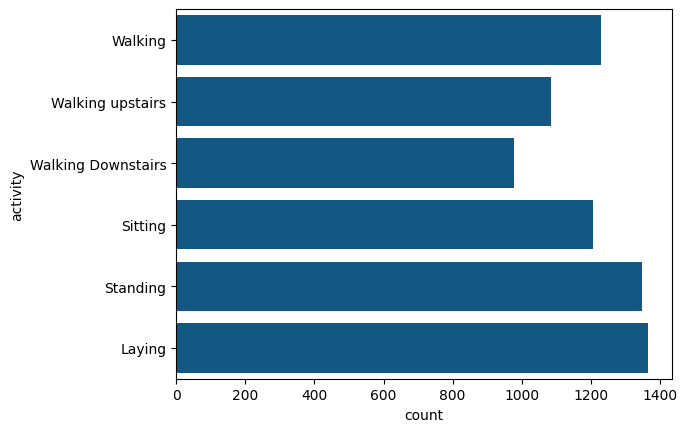

In [201]:
seaborn.countplot(y = "activity", data = graph,orient="h",
                  order = cls_order, color='#005b96')

## Inżynieria cech
Z racji na dużą ilość kolumn w przykładach należało przeprowadzić redukcję danych. Redukcja ta ma na celu usunięcie redundantnych kolumn i użycie do modelu jedyni tych najważniejszych. W tym celu dla każdej kolumny wytrenowano regresje logistyczną wykorzystując do przewidywanie jedynie tą kolumnę. Dzięki temu można było w przybliżeniu określić które kolumny zawierają najwięcej informacji.

In [202]:
NUMBER_OF_ATTRIBUTES = len(df.columns) - 1
NUMBER_OF_ATTRIBUTES

561

In [203]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1]

In [204]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

In [205]:
accuracy_list = []
for i in range(NUMBER_OF_ATTRIBUTES):
    feature_i = X_train.iloc[:,i].to_frame()
    feature_i_val = X_val.iloc[:,i].to_frame()
    lr = LogisticRegression(max_iter=1000)
    lr.fit(feature_i,y_train)
    y_hat = lr.predict(feature_i_val)
    acc = accuracy_score(y_hat, y_val)
    accuracy_list.append(acc)

Text(0.5, 0, 'Accuracy')

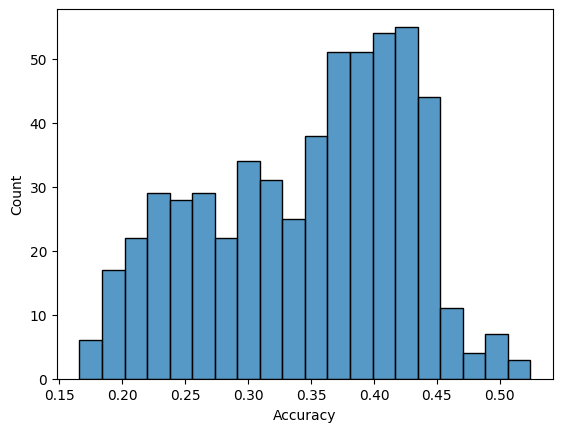

In [206]:
plot = seaborn.histplot(accuracy_list, bins=20)
plot.set_xlabel('Accuracy')

Następnie na podstawie macierzy korelacji oraz wartości 'accuracy' dla modeli pojedynczych kolumn usunięto kolumny które miały korelację modulo z innymi kolumnami przynajmniej 70%. Do usunięcia wybierano kolumnę której pojedynczy model dawał niższą wartość wskaźnika 'accuracy'.

In [207]:
X_corr=X_train.corr()
tab=[]
for i in range(NUMBER_OF_ATTRIBUTES):
    for j in range(i+1,NUMBER_OF_ATTRIBUTES):
        if (abs(X_corr.iloc[i,j])>0.7):
            tab.append([i,j])
to_deletion = []
for pair in tab:
    f1 = pair[0]
    f2 = pair[1]
    if f1 in to_deletion or f2 in to_deletion:
        continue
    else:
        if accuracy_list[f1] > accuracy_list[f2]:
            to_deletion.append(f2)
        else:
            to_deletion.append(f1)


##### Opis podziału
Dalej X i y - do fit, X_test - do predict, y_test - do score \
X_all i X_test_all do fit i predict dla sprawdzenia jak radzą sobie modele przy niezmodyfikowanym zbiorze danych\
X_train i y_train i X_val i y_val do usuwania "nadmiarowych" kolumn z danych 

In [208]:
X_train = X_train.drop(X_train.columns[to_deletion], axis=1)
X_val = X_val.drop(X_val.columns[to_deletion], axis=1)
X_test_all=X_test
X_test = X_test.drop(X_test.columns[to_deletion], axis=1)
X_all=X
X = X.drop(X.columns[to_deletion], axis=1)

In [209]:
X_all.shape

(7209, 561)

In [210]:
X.shape

(7209, 130)

In [211]:
print(f"{(X.shape[1] / NUMBER_OF_ATTRIBUTES):.2%} of the features were left")

23.17% of the features were left


In [212]:
print(f"{(1 - X.shape[1] / NUMBER_OF_ATTRIBUTES):.2%} of the features were deleted")

76.83% of the features were deleted


In [213]:
accuracy_list_2 = []
for i in range(X.shape[1]):
    feature_i = X_train.iloc[:,i].to_frame()
    feature_i_val = X_val.iloc[:,i].to_frame()
    lr = LogisticRegression(max_iter=1000)
    lr.fit(feature_i,y_train)
    y_hat = lr.predict(feature_i_val)
    acc = accuracy_score(y_hat, y_val)
    accuracy_list_2.append(acc)

In [214]:
best_ten = sorted(range(len(accuracy_list_2)), key=lambda k: accuracy_list_2[k])[0:10]
X_ten = X.iloc[:,best_ten]
cors = X_ten.corr()

Z macierzy korelacji przedstawiającej 10 najlepszych kolumn możemy wyczytać, że korelacje pomiędzy kolumnami nie przekraczają 0.7 i są w większości zdecydowanie niższe.

<AxesSubplot:>

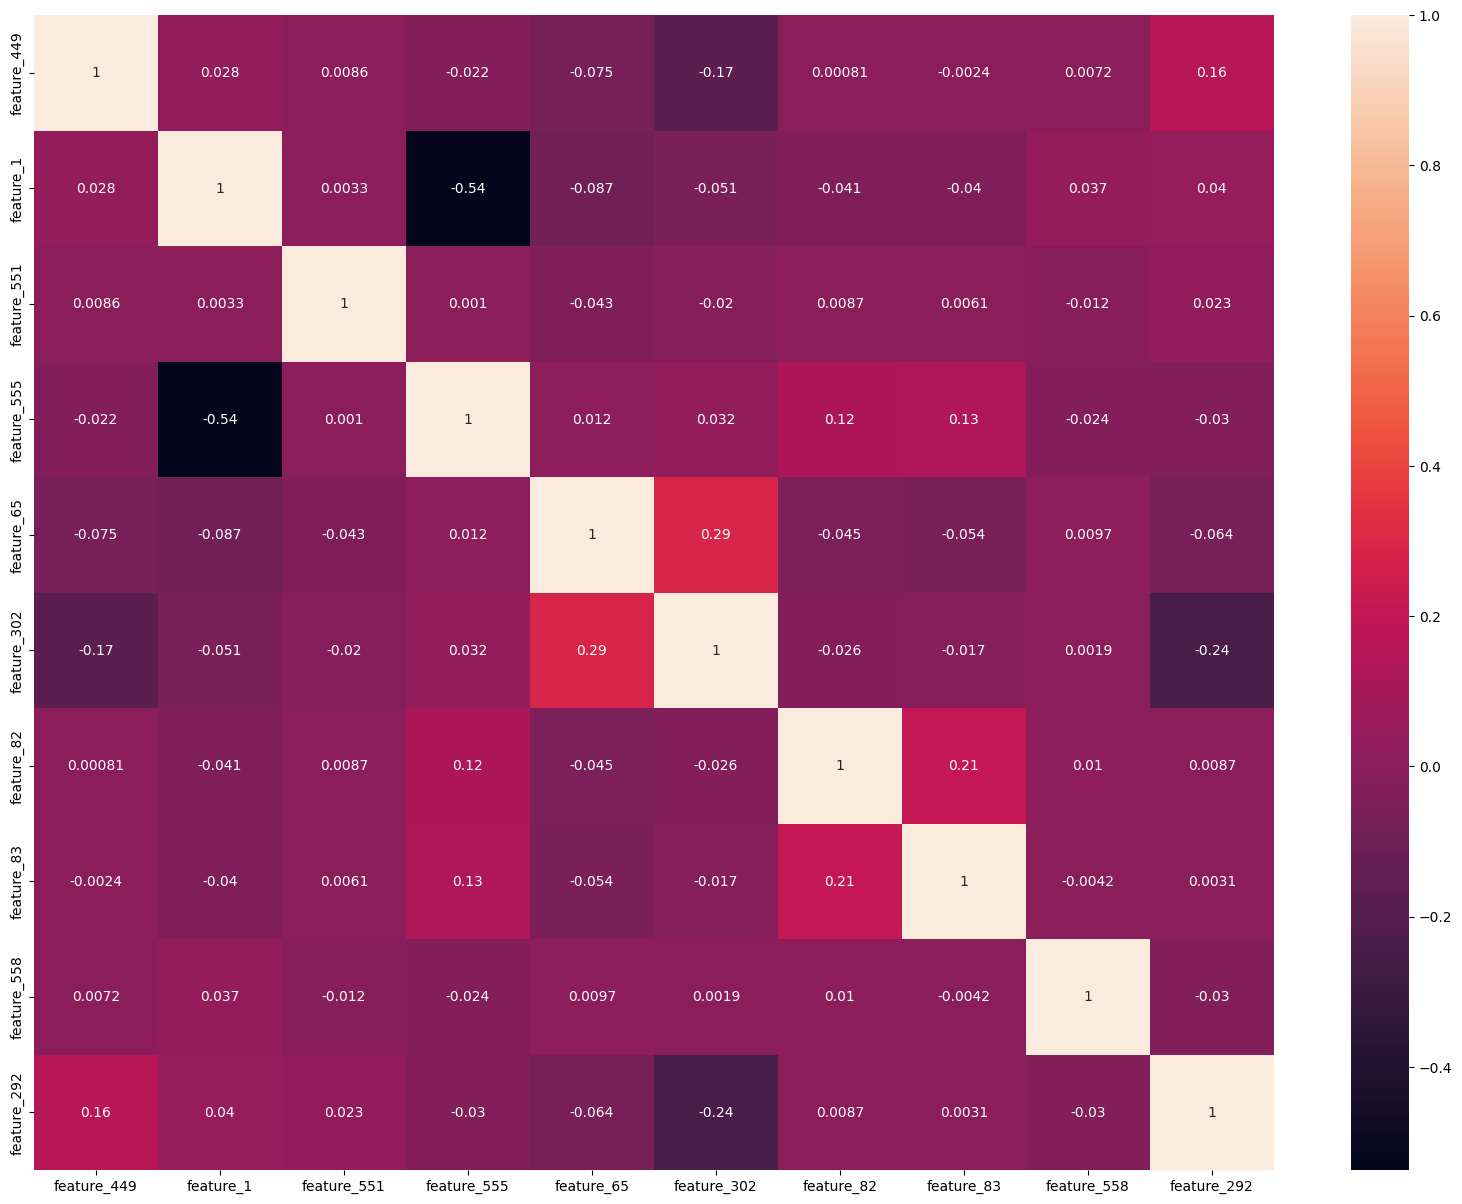

In [215]:
fig, ax = plt.subplots(figsize=(20, 15))
seaborn.heatmap(cors,annot=True)

In [216]:
len(to_deletion)/NUMBER_OF_ATTRIBUTES

0.768270944741533

### T-SNE plot

[Text(0.5, 1.0, 'Data T-SNE projection')]

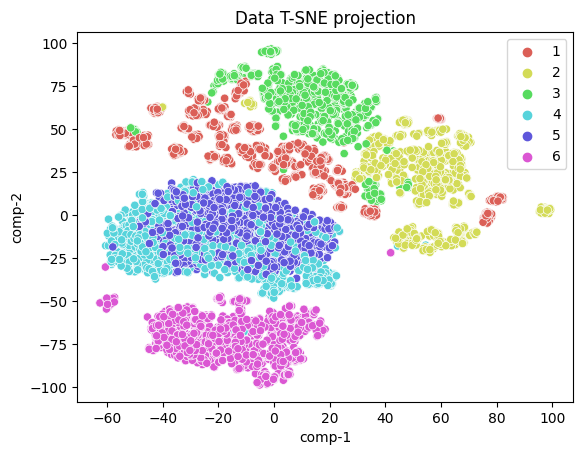

In [280]:
tsne = TSNE(n_components=2, random_state=42)
z = tsne.fit_transform(X_all)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df).set(title="Data T-SNE projection") 

## Trenowanie modeli

#### Regresja logistyczna niezmodyfikowane dane

In [218]:
all_var_lr = LogisticRegression(max_iter=100000)
all_var_lr.fit(X_all,y)
y_hat = all_var_lr.predict(X_test_all)
y_hat2 = all_var_lr.predict(X_all)
Wyniki_1={'Method':['unmodified data'],
    'Model':['LogisticRegression'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2,y)]}
df_Wyniki_1 = pd.DataFrame(data=Wyniki_1)
df_Wyniki_1

,Method,Model,Accuracy test,Accuracy train
0,unmodified data,LogisticRegression,0.982201,0.992232


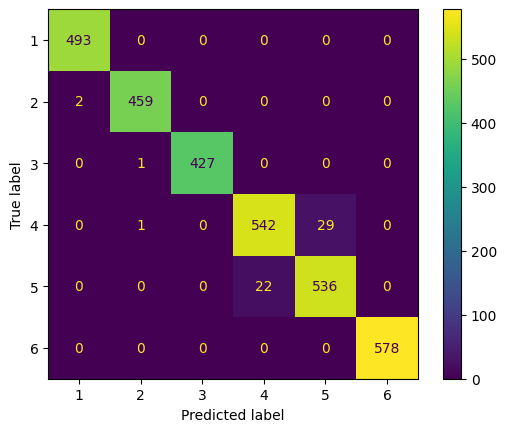

In [219]:
plot_confusion_matrix(all_var_lr,X_test_all,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

In [148]:
biases = all_var_lr.intercept_.reshape(6,1)
coefficients = np.array([all_var_lr.coef_[i,:] for i in range(6)])
percentage = coefficients / np.repeat(biases, NUMBER_OF_ATTRIBUTES, axis=1)

0.6702317290552585


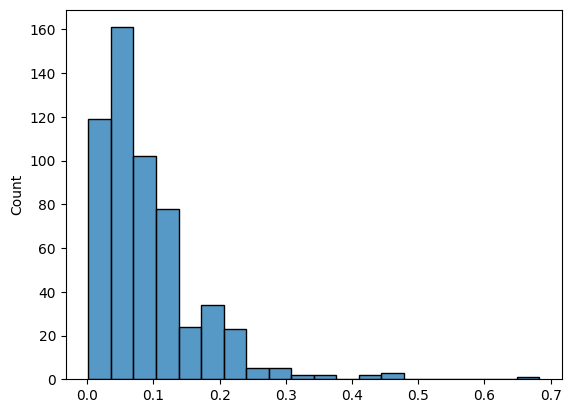

In [149]:
maxi = np.amax(np.abs(percentage), axis=0)
maxi.shape
mask = (maxi < 5)
seaborn.histplot(maxi[mask], bins=20)
print((np.amax(np.abs(percentage), axis=0) < 0.10).mean())

#### Regresja logistyczna penalty='l2'

In [220]:
lr = LogisticRegression(max_iter=10000, C=1, penalty='l2')
lr.fit(X,y)
y_hat = lr.predict(X_test)
y_hat2 = lr.predict(X)
Wyniki_2={'Method':['penalty=l2'],
    'Model':['LogisticRegression'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_2 = pd.DataFrame(data=Wyniki_2)
df_Wyniki_2

,Method,Model,Accuracy test,Accuracy train
0,penalty=l2,LogisticRegression,0.956311,0.972257


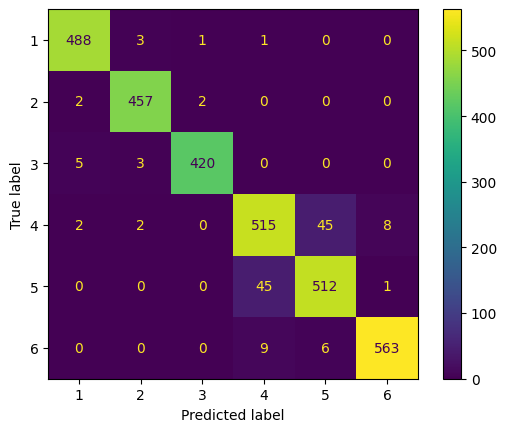

In [221]:
plot_confusion_matrix(lr,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

In [180]:
biases = lr.intercept_.reshape(6,1)
coefficients = np.array([lr.coef_[i,:] for i in range(6)])
percentage = coefficients / np.repeat(biases, 130, axis=1)

0.9153846153846154


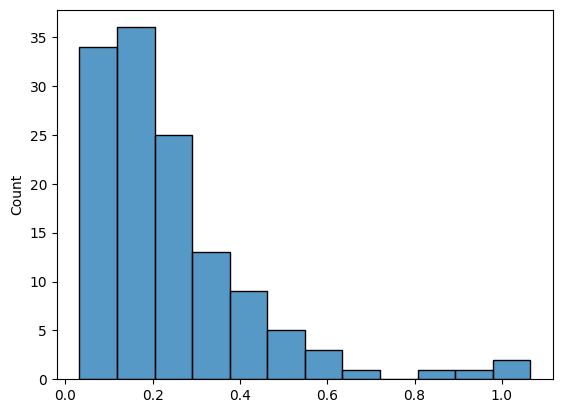

In [181]:
maxi = np.amax(np.abs(percentage), axis=0)
maxi.shape
mask = (maxi < 5)
seaborn.histplot(maxi[mask], bins=12)
print((np.amax(np.abs(percentage), axis=0) < 0.5).mean())

#### Regresja logistyczna penalty='none'

In [222]:
lr = LogisticRegression(max_iter=10000, penalty='none',random_state=0)
lr.fit(X,y)
y_hat = lr.predict(X_test)
y_hat2 = lr.predict(X)
Wyniki_3={'Method':['penalty=none'],
    'Model':['LogisticRegression'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_3 = pd.DataFrame(data=Wyniki_3)
df_Wyniki_3

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,Method,Model,Accuracy test,Accuracy train
0,penalty=none,LogisticRegression,0.938835,0.98599


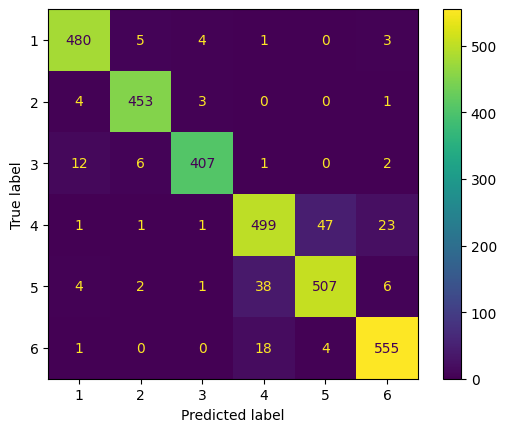

In [223]:
plot_confusion_matrix(lr,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

In [184]:
biases = lr.intercept_.reshape(6,1)
coefficients = np.array([lr.coef_[i,:] for i in range(6)])
percentage = coefficients / np.repeat(biases, 130, axis=1)

0.05384615384615385


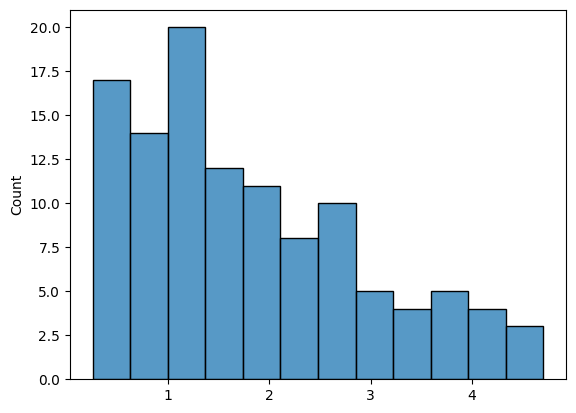

In [185]:
maxi = np.amax(np.abs(percentage), axis=0)
maxi.shape
mask = (maxi < 5)
seaborn.histplot(maxi[mask], bins=12)
print((np.amax(np.abs(percentage), axis=0) < 0.5).mean())

#### Wniosek

Pomimo że dla pierwszej regresji logistycznej zostały użyte wszystkie kolumny, to wartość accuracy była większa o jedynie kilka punktów procentowych. Z powyższych wykresów możemy wyczytać, że większość kolumn wchodzi do wzory na regresję z bardzo małymi współczynnikami, niemal równymi zero. Problem ten nie występuje w drugim przykładzie, z tego powodu w dalszych rozważaniach będzie używana jedynie regresje logistyczna wytrenowana na mniejszej ilości kolumn.

#### Himerparametry

Poniżej zostały jeszcze wykonane eksperymenty mające na celu znalezienie najlepszych parametrów dla regresji logistycznej. Zostało wykorzystane przeszukiwanie GridSearch zaimplementowane przez nas, oraz przeszukiwanie RandomSearchCV. 

#### Regresja Logistyczna nasz GridSearch

In [224]:
max_C = 0
max_acc = 0
max_lr = None
C_values = [0.01,0.1,0.3,1,3,10,30,100]

for C in C_values:
    lr = LogisticRegression(max_iter=10000, C=C, penalty='l2')
    lr.fit(X_train,y_train)
    y_cv = lr.predict(X_val)
    acc = accuracy_score(y_cv, y_val)
    if acc > max_acc:
        max_acc = acc
        max_C = C
        max_lr = lr

y_hat = max_lr.predict(X_test)
y_hat2 = max_lr.predict(X)
acc = accuracy_score(y_hat, y_test)

print(f"Best accuracy: {acc}, C: {max_C}")

Best accuracy: 0.9559870550161812, C: 3


In [225]:
Wyniki_4={'Method':['our GridSearch'],
    'Model':['LogisticRegression'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_4 = pd.DataFrame(data=Wyniki_4)
df_Wyniki_4

,Method,Model,Accuracy test,Accuracy train
0,our GridSearch,LogisticRegression,0.955987,0.973089


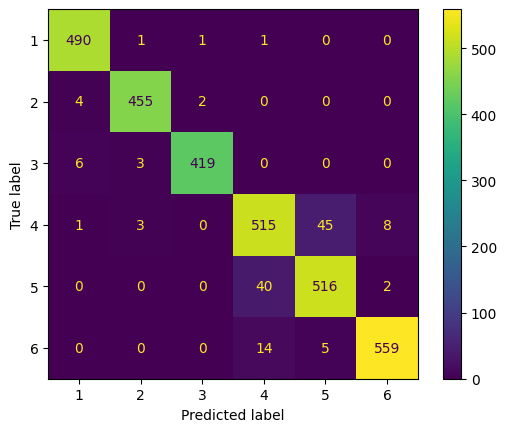

In [226]:
plot_confusion_matrix(max_lr,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

#### Regresja Logistyczna RandomizedSearch

In [227]:
model = LogisticRegression(max_iter=2000, random_state=0)
distributions = dict(C=uniform(loc=0, scale=300),
                     penalty=['none', 'l1', 'l2', 'elasticnet'])
clf = RandomizedSearchCV(model, distributions, random_state=0)
lr = clf.fit(X, y)
lr.best_params_

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

{'C': 115.03245564773331, 'penalty': 'l2'}

In [228]:
y_hat =  lr.predict(X_test)
y_hat2 =  lr.predict(X)
Wyniki_5={'Method':['RandomizedSearchCV'],
    'Model':['LogisticRegression'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_5 = pd.DataFrame(data=Wyniki_5)
df_Wyniki_5

,Method,Model,Accuracy test,Accuracy train
0,RandomizedSearchCV,LogisticRegression,0.955987,0.980857


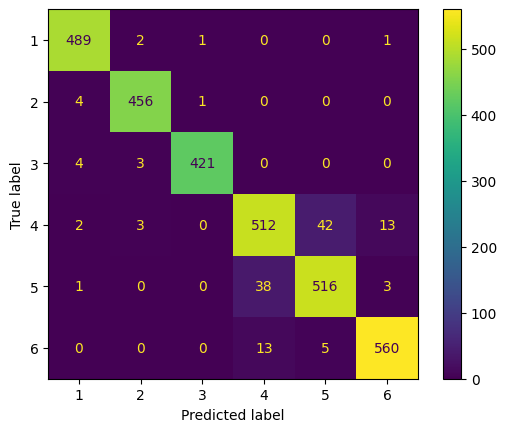

In [229]:
plot_confusion_matrix(lr,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

### SVM

Kolejnym klasyfikatorem wykorzystanym w projekcie jest SVM. Intuicja podpowiada, że powinien on w najgorszym przypadku uzskać taki sam wynik jak regresja logistyczna. Dodatkowo została zastosowane metoda RandomSearchCV do znalezienia hiperparametrów modelu. Do parametrów zaliczało się m.in jądro, które pozwoliło na zbudowanie nieliniowego klasyfikatora.

#### SVM default

In [230]:
svm = SVC()
svm.fit(X,y)
y_hat = svm.predict(X_test)
y_hat2 = svm.predict(X)
Wyniki_6={'Method':['default'],
    'Model':['SVC'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_6 = pd.DataFrame(data=Wyniki_6)
df_Wyniki_6

,Method,Model,Accuracy test,Accuracy train
0,default,SVC,0.963754,0.975031


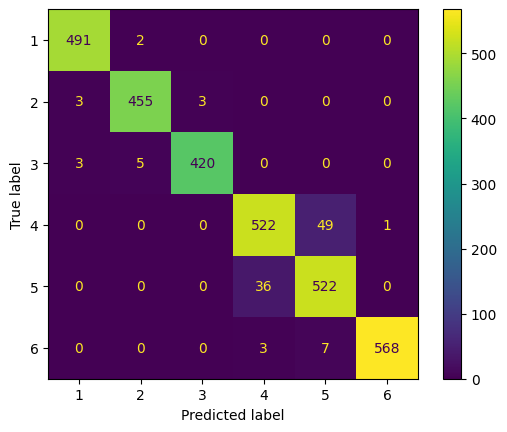

In [231]:
plot_confusion_matrix(svm,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

#### SVM RandomizedSearch

In [232]:
model = SVC(random_state=0)
distributions = dict(C=uniform(loc=0, scale=500),
                     kernel=['linear', 'sigmoid', 'rbf'],
                     coef0=uniform(loc=0.001, scale=500))
clf = RandomizedSearchCV(model, distributions, random_state=0)
svm = clf.fit(X, y)
svm.best_params_

{'C': 311.78184839298615, 'coef0': 192.19185364634993, 'kernel': 'rbf'}

In [233]:
y_hat = svm.predict(X_test)
y_hat2 = svm.predict(X)
Wyniki_7={'Method':['RandomizedSearchCV'],
    'Model':['SVC'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_7 = pd.DataFrame(data=Wyniki_7)
df_Wyniki_7

,Method,Model,Accuracy test,Accuracy train
0,RandomizedSearchCV,SVC,0.981553,1.0


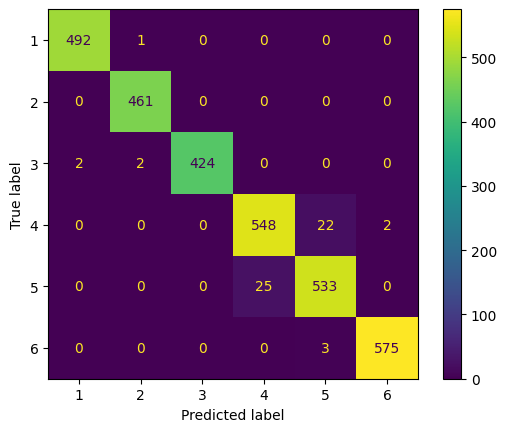

In [234]:
plot_confusion_matrix(svm,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

### Naiwny klasyfikator Bayesa

W ramach testów zbudowano również naiwny klasyfikator Bayesa. Był on bardziej wykorzystany z ciekawości, a niżeli żeby konkurować z pozostałymi modelami, ponieważ główną wadą tego klasyfikatora jest fakt, że zakłada on pełną niezależność pomiędzy danymi, co prawie nigdy nie występuje w prawdziwym świecie, a już na pewno nie występuje w naszym zbiorze danych.

In [235]:
nb = GaussianNB()
nb.fit(X,y)
y_hat = nb.predict(X_test)
y_hat2 = nb.predict(X)
Wyniki_8={'Method':['default'],
    'Model':['GaussianNB'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_8 = pd.DataFrame(data=Wyniki_8)
df_Wyniki_8

,Method,Model,Accuracy test,Accuracy train
0,default,GaussianNB,0.853074,0.855875


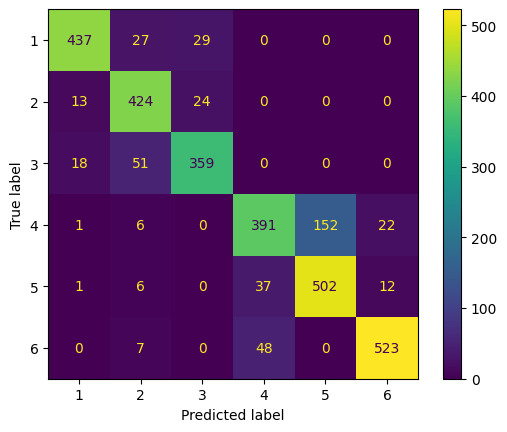

In [236]:
plot_confusion_matrix(nb,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

## Drzewa

#### DecisionTreeClassifier default

In [237]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X,y)

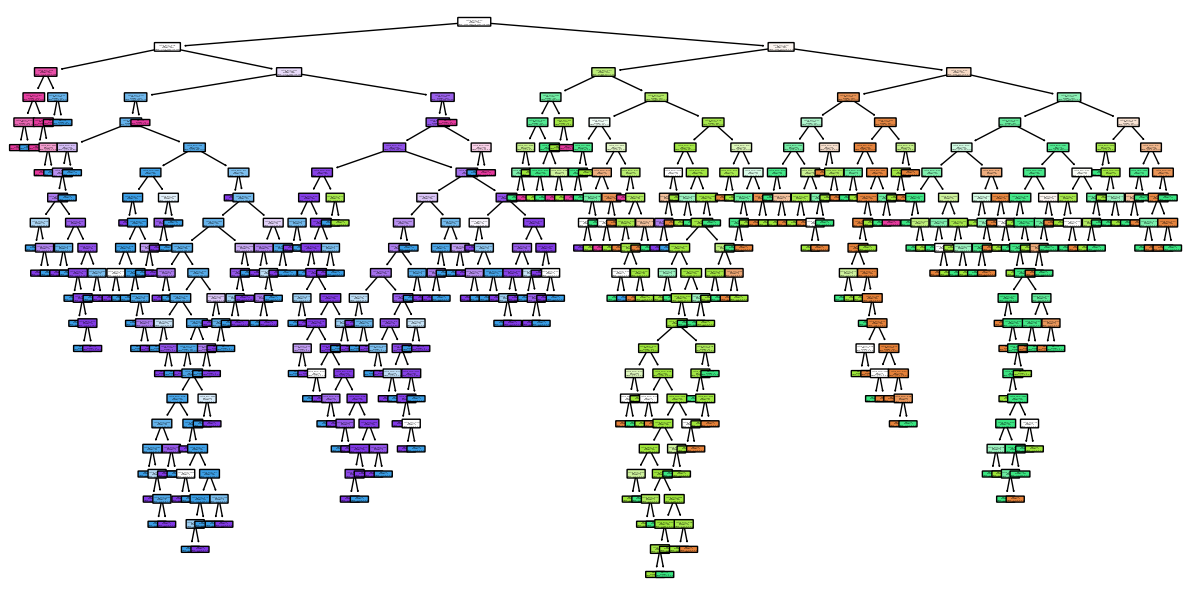

In [238]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names=["1","2","3","4","5","6"],
          feature_names=X.columns);


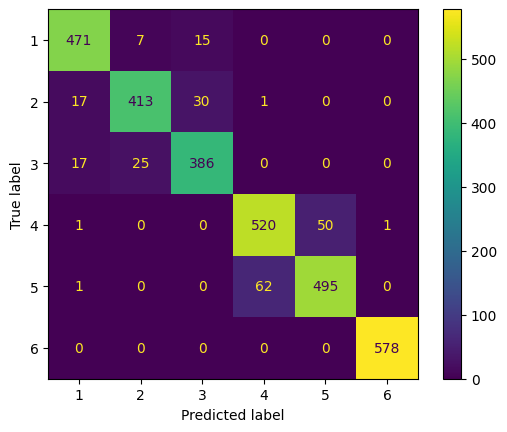

In [239]:
plot_confusion_matrix(clf_dt,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

In [240]:
y_hat = clf_dt.predict(X_test)
y_hat2 = clf_dt.predict(X)
Wyniki_9={'Method':['default'],
    'Model':['DecisionTreeClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_9 = pd.DataFrame(data=Wyniki_9)
df_Wyniki_9

,Method,Model,Accuracy test,Accuracy train
0,default,DecisionTreeClassifier,0.926537,1.0


#### DecisionTreeClassifier własna hiperparametryzacja

In [241]:
path= clf_dt.cost_complexity_pruning_path(X,y)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts= []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0,ccp_alpha=ccp_alpha)
    clf_dt.fit(X,y)
    clf_dts.append(clf_dt)

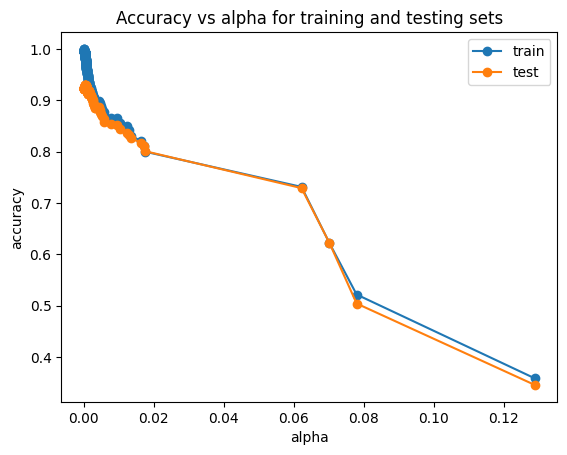

In [242]:
train_scores = [clf_dt.score(X,y) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test,y_test) for clf_dt in clf_dts]

fig, ax=plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o',label="train")
ax.plot(ccp_alphas, test_scores, marker='o',label="test")
ax.legend()
plt.show()


In [243]:
max_accuracy, ccp_alpha_max = max(test_scores),ccp_alphas[test_scores.index(max(test_scores))]
print(f"Best accuracy: {max_accuracy}, for ccp_alpha: {ccp_alpha_max}")

Best accuracy: 0.9288025889967637, for ccp_alpha: 0.0002747110773842062


<AxesSubplot:xlabel='tree'>

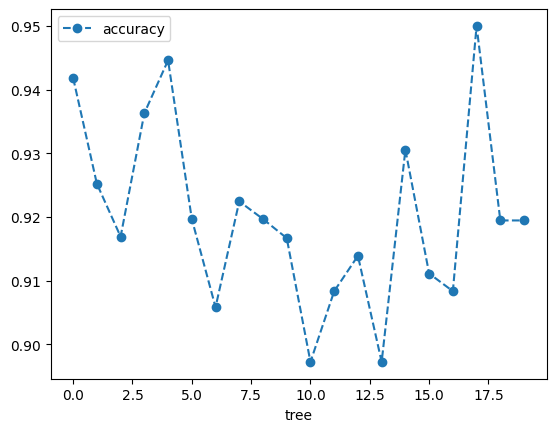

In [244]:
clf_dt = DecisionTreeClassifier(random_state=42,ccp_alpha=ccp_alpha_max)

scores = cross_val_score(clf_dt, X,y,cv=20)
df = pd.DataFrame(data={'tree':range(20),'accuracy': scores})

df.plot(x='tree', y='accuracy',marker='o',linestyle='--')

<AxesSubplot:xlabel='alpha'>

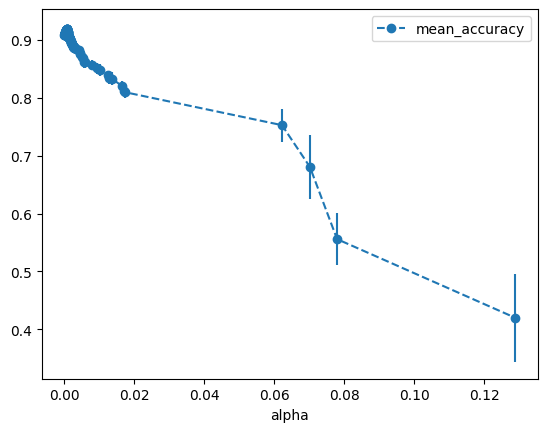

In [245]:
alpha_loop_values=[]

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42,ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X,y,cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores),np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values,
                            columns=['alpha','mean_accuracy','std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')

In [246]:
alpha_results.sort_values(by=['mean_accuracy'], ascending=False).head()

,alpha,mean_accuracy,std
135,0.000731,0.918296,0.005105
134,0.000718,0.918296,0.005105
133,0.000668,0.918158,0.005444
136,0.000733,0.918158,0.005137
137,0.000752,0.917880,0.005929


In [247]:
best_ccp_alpha=alpha_results.sort_values(by=['mean_accuracy'], ascending=False).iloc[0,0]
clf_dt_pruned = DecisionTreeClassifier(random_state=42,ccp_alpha=best_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X,y)

In [248]:
y_hat = clf_dt_pruned.predict(X_test)
y_hat2 = clf_dt_pruned.predict(X)
Wyniki_10={'Method':['our hyperparameter tuning'],
    'Model':['DecisionTreeClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_10 = pd.DataFrame(data=Wyniki_10)
df_Wyniki_10

,Method,Model,Accuracy test,Accuracy train
0,our hyperparameter tuning,DecisionTreeClassifier,0.927508,0.963795


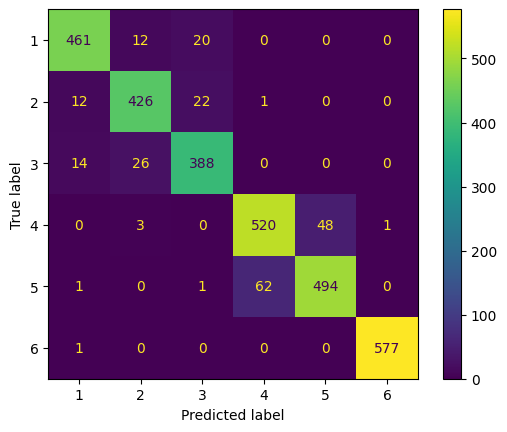

In [249]:
plot_confusion_matrix(clf_dt_pruned,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

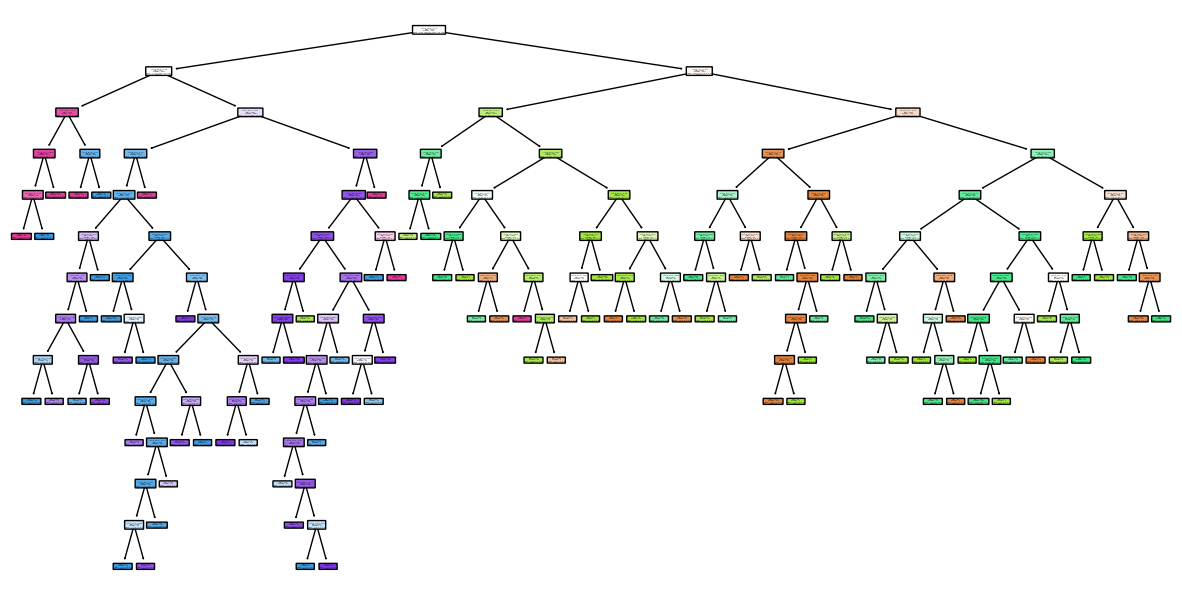

In [250]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["1","2","3","4","5","6"],
          feature_names=X.columns);

### RandomForestClassifier

#### RandomForestClassifier default

In [252]:
clf_RFC = RandomForestClassifier(random_state=42)
clf_RFC.fit(X,y)
y_hat = clf_RFC.predict(X_test)
y_hat2 = clf_RFC.predict(X)
Wyniki_11={'Method':['default'],
    'Model':['RandomForestClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_11 = pd.DataFrame(data=Wyniki_11)
df_Wyniki_11

,Method,Model,Accuracy test,Accuracy train
0,default,RandomForestClassifier,0.972816,1.0


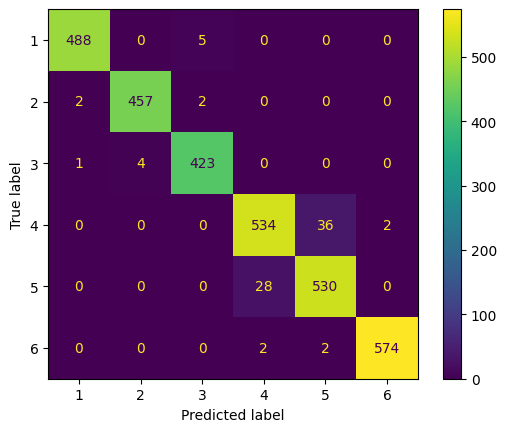

In [253]:
plot_confusion_matrix(clf_RFC,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

#### RandomForestClassifier niezmodyfikowane dane

In [254]:
clf_RFC = RandomForestClassifier(random_state=42)
clf_RFC.fit(X_all,y)
y_hat = clf_RFC.predict(X_test_all)
y_hat2 = clf_RFC.predict(X_all)
Wyniki_12={'Method':['unmodified data'],
    'Model':['RandomForestClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_12 = pd.DataFrame(data=Wyniki_12)
df_Wyniki_12

,Method,Model,Accuracy test,Accuracy train
0,unmodified data,RandomForestClassifier,0.977346,1.0


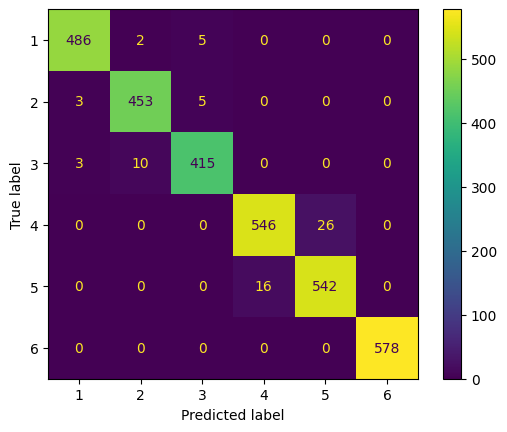

In [255]:
plot_confusion_matrix(clf_RFC,X_test_all,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

#### RandomForestClassifier GridSearch

In [256]:
#komurka wywołuje się 1.5h
#rand_forest = RandomForestClassifier(random_state=42)
#distributions= dict(n_estimators=np.linspace(50, 200, num=6).astype(int),
#                    min_samples_split=[1,2,3],
#                     max_depth=[20,40,60,None],
#                     min_samples_leaf=[1,2],
#                   criterion=['entropy','gini'])
#clf = GridSearchCV(rand_forest, distributions)
#search = clf.fit(X,y)
#search.best_params_
#{'criterion': 'gini',
# 'max_depth': 20,
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'n_estimators': 200}

In [258]:
clf_RFC = RandomForestClassifier(criterion='gini',max_depth=20,
                                 min_samples_leaf=1,min_samples_split=2,
                                 n_estimators=200,random_state=42)
clf_RFC.fit(X,y)
y_hat = clf_RFC.predict(X_test)
y_hat2 = clf_RFC.predict(X)
Wyniki_13={'Method':['RandomizedSearchCV'],
    'Model':['RandomForestClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_13 = pd.DataFrame(data=Wyniki_13)
df_Wyniki_13

,Method,Model,Accuracy test,Accuracy train
0,RandomizedSearchCV,RandomForestClassifier,0.97411,1.0


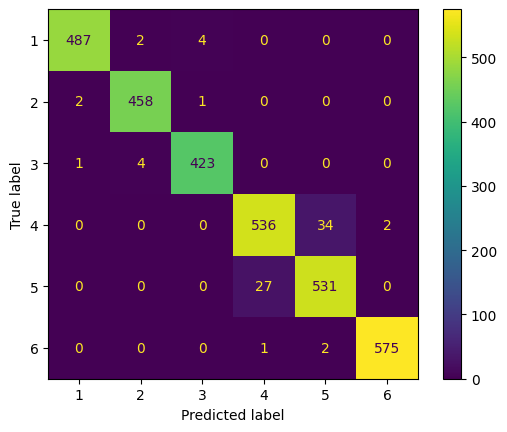

In [259]:
plot_confusion_matrix(clf_RFC,X_test,y_test,
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

## Feature importance

In [260]:
feature_importances2=pd.DataFrame(clf_RFC.feature_importances_,
                                 index=X.columns,
                                 columns=['importance']).sort_values('importance', ascending=False).head(10)

In [261]:
feature_importances2

,importance
feature_560,0.078020
feature_275,0.048782
feature_59,0.042003
feature_55,0.040335
feature_490,0.026969
feature_70,0.026105
feature_393,0.025560
feature_38,0.025002
feature_422,0.022870
feature_64,0.021462


In [262]:
result = permutation_importance(
    clf_RFC, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [263]:
importances = clf_RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_RFC.estimators_], axis=0)
names=list(X.columns)
importances_mean=result['importances_mean']
importances_std=result['importances_std']

df1 = pd.DataFrame(names,columns =['Names'])
df2 = pd.DataFrame(std,columns =['std'])
df3 = pd.DataFrame(importances,columns =['importances'])
df4 = pd.DataFrame(importances_mean,columns =['importances_mean'])
df5 = pd.DataFrame(importances_std,columns =['importances_std'])
df=pd.concat([df1,df2,df3,df4,df5], axis=1)
df=pd.merge(df,columns_info,left_on='Names',right_on='name')
df=df.sort_values('importances', ascending=False).head(20)
df

,Names,std,importances,importances_mean,importances_std,name,type,description
129,feature_560,0.049754,0.078020,0.061327,0.003890,feature_560,float,"angle(Y,gravityMean)"
67,feature_275,0.061725,0.048782,0.005405,0.001350,feature_275,float,fBodyAcc-max()-X
9,feature_59,0.040521,0.042003,0.016019,0.001442,feature_59,float,tGravityAcc-energy()-Z
7,feature_55,0.041416,0.040335,0.004142,0.000878,feature_55,float,tGravityAcc-min()-Z
109,feature_490,0.058902,0.026969,0.000356,0.000824,feature_490,float,"fBodyGyro-bandsEnergy()-9,16"
16,feature_70,0.025926,0.026105,0.000291,0.000785,feature_70,float,"tGravityAcc-arCoeff()-Y,1"
90,feature_393,0.060506,0.025560,0.000324,0.000324,feature_393,float,"fBodyAccJerk-bandsEnergy()-49,64"
3,feature_38,0.017877,0.025002,0.004239,0.001407,feature_38,float,"tBodyAcc-correlation()-X,Y"
93,feature_422,0.054398,0.022870,0.001197,0.000710,feature_422,float,"fBodyAccJerk-bandsEnergy()-1,24"
13,feature_64,0.018709,0.021462,0.006893,0.000767,feature_64,float,tGravityAcc-entropy()-Y


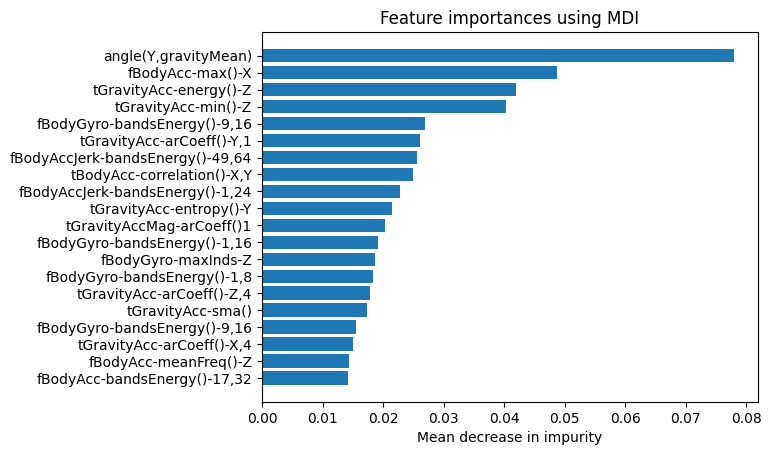

In [264]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(df['description'].values.tolist()))

ax.barh(y_pos, df['importances'].values.tolist(), align='center')
ax.set_yticks(y_pos,labels=df['description'].values.tolist())
ax.invert_yaxis()  
ax.set_xlabel('Mean decrease in impurity')
ax.set_title('Feature importances using MDI')

plt.show()

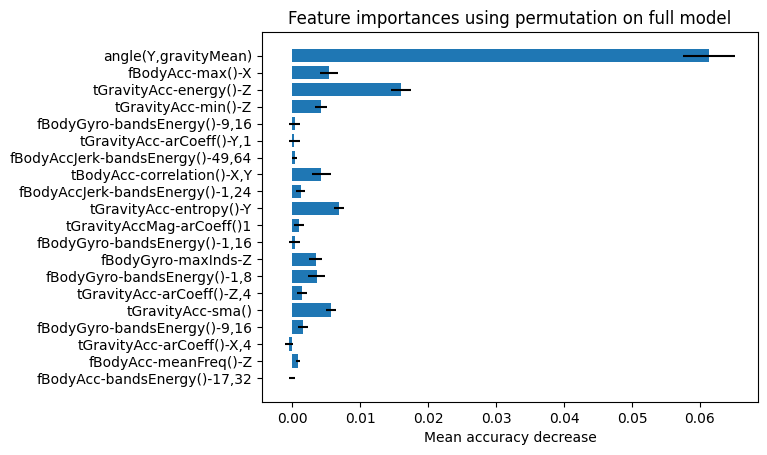

In [265]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(df['description'].values.tolist()))
error = df['importances_std'].values.tolist()

ax.barh(y_pos, df['importances_mean'].values.tolist(), xerr=error, align='center')
ax.set_yticks(y_pos,labels=df['description'].values.tolist())
ax.invert_yaxis()  
ax.set_xlabel('Mean accuracy decrease')
ax.set_title('Feature importances using permutation on full model')

plt.show()

### ExtraTreesClassifier

#### ExtraTreesClassifier default

In [266]:
clf_ETC = ExtraTreesClassifier(random_state=42)
clf_ETC.fit(X,y)
y_hat = clf_ETC.predict(X_test)
y_hat2 = clf_ETC.predict(X)
Wyniki_14={'Method':['default'],
    'Model':['ExtraTreesClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_14 = pd.DataFrame(data=Wyniki_14)
df_Wyniki_14

,Method,Model,Accuracy test,Accuracy train
0,default,ExtraTreesClassifier,0.971197,1.0


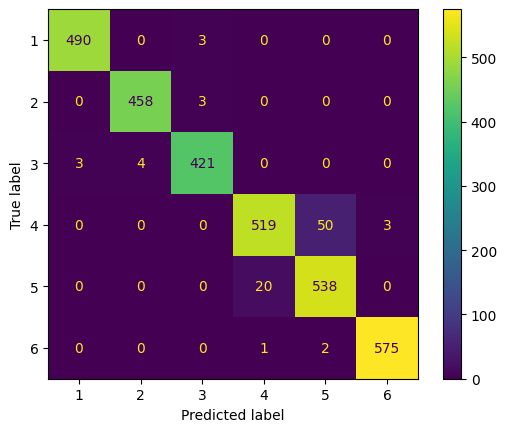

In [267]:
plot_confusion_matrix(clf_ETC,X_test,y_test, 
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

#### ExtraTreesClassifier niemodyfikowane dane

In [268]:
clf_ETC = ExtraTreesClassifier(random_state=42)
clf_ETC.fit(X_all,y)
y_hat = clf_ETC.predict(X_test_all)
y_hat2 = clf_ETC.predict(X_all)
Wyniki_15={'Method':['unmodified data'],
    'Model':['ExtraTreesClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_15 = pd.DataFrame(data=Wyniki_15)
df_Wyniki_15

,Method,Model,Accuracy test,Accuracy train
0,unmodified data,ExtraTreesClassifier,0.978641,1.0


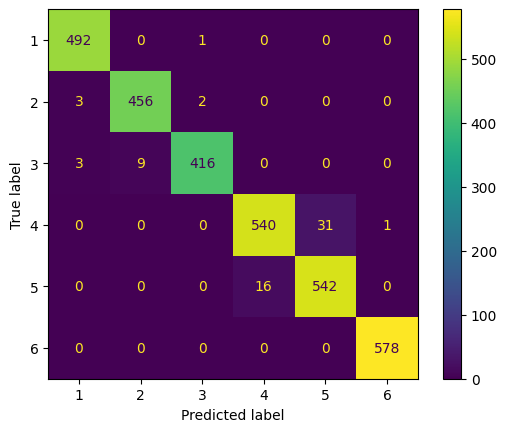

In [269]:
plot_confusion_matrix(clf_ETC,X_test_all,y_test, 
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

#### MLPClassifier default

In [270]:
MLP=MLPClassifier(alpha=1, max_iter=100000)
MLP.fit(X,y)
y_hat = MLP.predict(X_test)
y_hat2 = MLP.predict(X)
Wyniki_16={'Method':['default'],
    'Model':['MLPClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_16 = pd.DataFrame(data=Wyniki_16)
df_Wyniki_16

,Method,Model,Accuracy test,Accuracy train
0,default,MLPClassifier,0.944984,0.953808


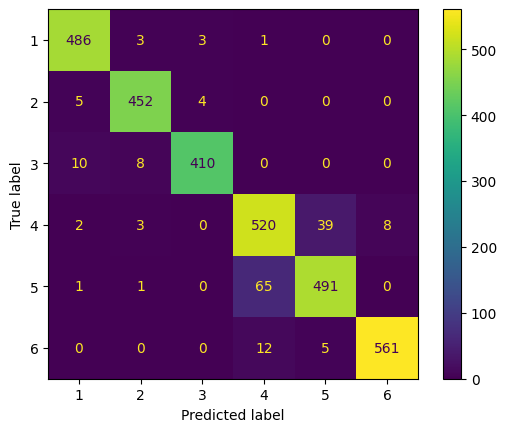

In [271]:
plot_confusion_matrix(MLP,X_test,y_test, 
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

#### AdaBoostClassifier default

In [272]:
Ada=AdaBoostClassifier()
Ada.fit(X,y)
y_hat = Ada.predict(X_test)
y_hat2 = Ada.predict(X)
Wyniki_17={'Method':['default'],
    'Model':['AdaBoostClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_17 = pd.DataFrame(data=Wyniki_17)
df_Wyniki_17

,Method,Model,Accuracy test,Accuracy train
0,default,AdaBoostClassifier,0.514887,0.529754


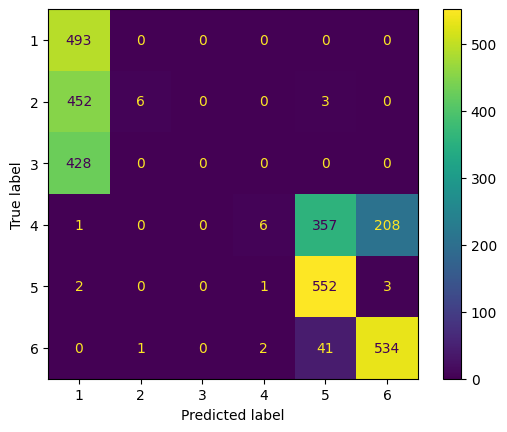

In [273]:
plot_confusion_matrix(Ada,X_test,y_test, 
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

#### QuadraticDiscriminantAnalysis default

In [274]:
QDA=QuadraticDiscriminantAnalysis()
QDA.fit(X,y)
y_hat = QDA.predict(X_test)
y_hat2 = QDA.predict(X)
Wyniki_18={'Method':['default'],
    'Model':['QuadraticDiscriminantAnalysis'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_18 = pd.DataFrame(data=Wyniki_18)
df_Wyniki_18

,Method,Model,Accuracy test,Accuracy train
0,default,QuadraticDiscriminantAnalysis,0.953074,0.985019


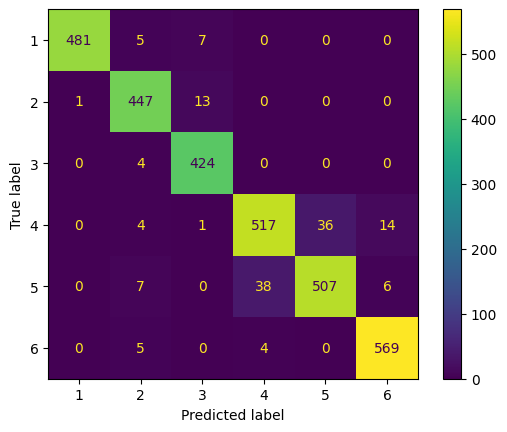

In [275]:
plot_confusion_matrix(QDA,X_test,y_test, 
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

#### KNeighborsClassifier default

In [276]:
KNC=KNeighborsClassifier()
KNC.fit(X,y)
y_hat = KNC.predict(X_test)
y_hat2 = KNC.predict(X)
Wyniki_19={'Method':['default'],
    'Model':['KNeighborsClassifier'],
           'Accuracy test':[accuracy_score(y_hat, y_test)],
         'Accuracy train':[accuracy_score(y_hat2, y)]}
df_Wyniki_19 = pd.DataFrame(data=Wyniki_19)
df_Wyniki_19

,Method,Model,Accuracy test,Accuracy train
0,default,KNeighborsClassifier,0.931392,0.962547


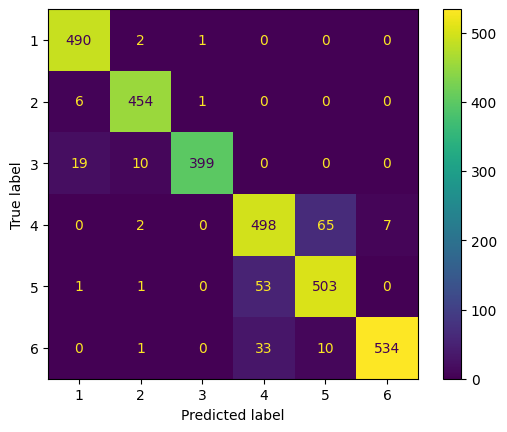

In [277]:
plot_confusion_matrix(KNC,X_test,y_test, 
                      display_labels=["1","2","3","4","5","6"],
                     values_format='d')

## Podsumowanie

In [285]:
result = pd.concat([
df_Wyniki_1,
df_Wyniki_2,
df_Wyniki_3,
df_Wyniki_4,
df_Wyniki_5,
df_Wyniki_6,
df_Wyniki_7,
df_Wyniki_8,
df_Wyniki_9,
df_Wyniki_10,
df_Wyniki_11,
df_Wyniki_12,
df_Wyniki_13,
df_Wyniki_14,
df_Wyniki_15,
df_Wyniki_16,
df_Wyniki_17,
df_Wyniki_18,
df_Wyniki_19
])
result.sort_values('Accuracy test', ascending=False)

,Method,Model,Accuracy test,Accuracy train
0,unmodified data,LogisticRegression,0.982201,0.992232
0,RandomizedSearchCV,SVC,0.981553,1.000000
0,unmodified data,ExtraTreesClassifier,0.978641,1.000000
0,unmodified data,RandomForestClassifier,0.977346,1.000000
0,RandomizedSearchCV,RandomForestClassifier,0.974110,1.000000
0,default,RandomForestClassifier,0.972816,1.000000
0,default,ExtraTreesClassifier,0.971197,1.000000
0,default,SVC,0.963754,0.975031
0,penalty=l2,LogisticRegression,0.956311,0.972257
0,our GridSearch,LogisticRegression,0.955987,0.973089


#### Podsumowanie
Wyniki wszystkich modeli zebraliśmy w jedną tebelę dla lepszego ich porównania. Zauważyć można, że najlepsze wyniki mają modele trenowane na danych, bez usuniętych zmiennych, ale może to też mieć swoje wady. Z modeli wybranych przez nas i trenownych "normalnie" najlepszy pod względem accuracy okazał się SVC wraz z metodą RandomizedSearchCV z 98.16% accuracy.